<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
import requests

url = "https://gist.githubusercontent.com/m-242/ecb3e130b76a3b12f7ef41b04f486405/raw/8a3e992841f55f33b9836631b62ac0250b5fe7f8/neuromancer.txt"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

text = response.text
# Now the 'text' variable contains the content of the novel.  You can use it in your model.
print(f"Downloaded {len(text)} characters.")

Downloaded 451934 characters.


In [4]:
split_point = int(0.2 * len(text))

# El libro era demasiado largo así que solo tomé el primer 20% para que lo pueda manejar con mis recursos
text = text[:split_point]
print(f"Using {len(text)} characters (20% of the original).")


Using 90386 characters (20% of the original).


In [5]:

# Remove repeated spaces
text = " ".join(text.split())
print(f"Processed text length: {len(text)}")


Processed text length: 90175


### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(text)

In [26]:
# la longitud de vocabulario de caracteres es:
vocab_size = len(chars_vocab)

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [13]:
idx2char[47]

'M'

###  Tokenizar

In [14]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in text]

In [15]:
tokenized_text[:1000]

[58,
 3,
 9,
 9,
 3,
 32,
 5,
 17,
 68,
 3,
 18,
 49,
 28,
 59,
 17,
 51,
 50,
 27,
 31,
 28,
 5,
 32,
 59,
 66,
 50,
 31,
 17,
 60,
 50,
 57,
 3,
 66,
 32,
 48,
 3,
 28,
 59,
 19,
 17,
 13,
 28,
 31,
 17,
 60,
 50,
 18,
 17,
 52,
 53,
 28,
 17,
 5,
 32,
 57,
 50,
 17,
 3,
 48,
 17,
 25,
 28,
 49,
 49,
 3,
 18,
 9,
 50,
 17,
 52,
 3,
 48,
 53,
 17,
 9,
 28,
 29,
 50,
 17,
 41,
 8,
 30,
 33,
 17,
 2,
 51,
 69,
 34,
 17,
 46,
 65,
 35,
 15,
 8,
 17,
 46,
 35,
 33,
 36,
 17,
 15,
 63,
 61,
 69,
 23,
 17,
 7,
 17,
 33,
 53,
 50,
 17,
 49,
 20,
 40,
 17,
 32,
 18,
 28,
 29,
 50,
 17,
 48,
 53,
 50,
 17,
 25,
 28,
 31,
 48,
 17,
 52,
 32,
 49,
 17,
 48,
 53,
 50,
 17,
 66,
 28,
 9,
 28,
 31,
 17,
 28,
 13,
 17,
 48,
 50,
 9,
 50,
 29,
 3,
 49,
 3,
 28,
 59,
 1,
 17,
 48,
 27,
 59,
 50,
 57,
 17,
 48,
 28,
 17,
 32,
 17,
 57,
 50,
 32,
 57,
 17,
 66,
 53,
 32,
 59,
 59,
 50,
 9,
 34,
 17,
 62,
 35,
 48,
 0,
 49,
 17,
 59,
 28,
 48,
 17,
 9,
 3,
 20,
 50,
 17,
 35,
 0,
 5,
 17,
 27,
 49,
 3,
 

### Organizando y estructurando el dataset

In [16]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [17]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [18]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [19]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [20]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [21]:
X.shape

(80975, 100)

In [22]:
X[100,:100]

array([63, 61, 69, 23, 17,  7, 17, 33, 53, 50, 17, 49, 20, 40, 17, 32, 18,
       28, 29, 50, 17, 48, 53, 50, 17, 25, 28, 31, 48, 17, 52, 32, 49, 17,
       48, 53, 50, 17, 66, 28,  9, 28, 31, 17, 28, 13, 17, 48, 50,  9, 50,
       29,  3, 49,  3, 28, 59,  1, 17, 48, 27, 59, 50, 57, 17, 48, 28, 17,
       32, 17, 57, 50, 32, 57, 17, 66, 53, 32, 59, 59, 50,  9, 34, 17, 62,
       35, 48,  0, 49, 17, 59, 28, 48, 17,  9,  3, 20, 50, 17, 35])

In [23]:
y[100,:100]

array([61, 69, 23, 17,  7, 17, 33, 53, 50, 17, 49, 20, 40, 17, 32, 18, 28,
       29, 50, 17, 48, 53, 50, 17, 25, 28, 31, 48, 17, 52, 32, 49, 17, 48,
       53, 50, 17, 66, 28,  9, 28, 31, 17, 28, 13, 17, 48, 50,  9, 50, 29,
        3, 49,  3, 28, 59,  1, 17, 48, 27, 59, 50, 57, 17, 48, 28, 17, 32,
       17, 57, 50, 32, 57, 17, 66, 53, 32, 59, 59, 50,  9, 34, 17, 62, 35,
       48,  0, 49, 17, 59, 28, 48, 17,  9,  3, 20, 50, 17, 35,  0])

In [20]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [24]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [27]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 70)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        54,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 70)       │        14,070 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,270 (266.68 KB)

 Trainable params: 68,270 (266.68 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [28]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [29]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 2.9009
 mean perplexity: 11.130653381347656 

Saved new model!
317/317 ━━━━━━━━━━━━━━━━━━━━ 114s 341ms/step - loss: 2.9000
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 2.2921
 mean perplexity: 9.901973724365234 

Saved new model!
317/317 ━━━━━━━━━━━━━━━━━━━━ 135s 319ms/step - loss: 2.2920
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 2.1738
 mean perplexity: 9.173011779785156 

Saved new model!
317/317 ━━━━━━━━━━━━━━━━━━━━ 140s 314ms/step - loss: 2.1737
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 2.0850
 mean perplexity: 8.824828147888184 

Saved new model!
317/317 ━━━━━━━━━━━━━━━━━━━━ 141s 311ms/step - loss: 2.0850
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 2.0139
 mean perplexity: 8.732154846191406 

Saved new model!
317/317 ━━━━━━━━━━━━━━━━━━━━ 141s 309ms/step - loss: 2.0138
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1.9581
 mean perp

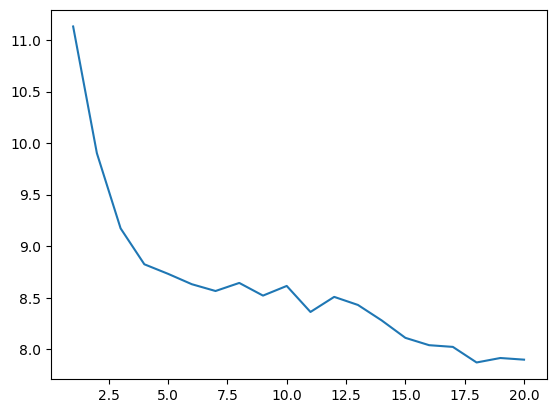

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [31]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [32]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [33]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://03e6c906313eb1b1d7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2136, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1662, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://03e6c906313eb1b1d7.gradio.live


### Generación de secuencias

In [34]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [37]:
input_text='Case'

generate_seq(model, input_text, max_length=max_context_size, n_words=50)

'Case was a sure of the bar the part of the bar the par'

Funcionaba mejor con palabras en vez de caracteres sueltos como era de esperarse.

###  Beam search y muestreo aleatorio

In [38]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [39]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [54]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=100,input="The plan was simple, first")

In [55]:
salidas[0]

array([33, 53, 50, 17, 25,  9, 32, 59, 17, 52, 32, 49, 17, 49,  3,  5, 25,
        9, 50,  1, 17, 13,  3, 31, 49, 48, 17, 13, 31, 28,  5, 17, 48, 53,
       50, 17, 25,  9, 32, 49, 48,  3, 66, 17, 13, 28, 31, 17, 48, 53, 50,
       17, 25,  9, 32, 49, 48,  3, 66, 17, 13, 28, 31, 17, 48, 53, 50, 17,
       25,  9, 32, 49, 48,  3, 66, 17, 13, 28, 31, 17, 48, 53, 50, 17, 25,
        9, 32, 49, 48,  3, 66, 17, 13, 28, 31, 17, 48, 53, 50, 17, 25,  9,
       32, 49, 48,  3, 66, 17, 13, 28, 31, 17, 48, 53, 50, 17, 18,  9, 32,
       66, 20, 17, 45, 32, 66, 20])

In [56]:
for i in range(10):
  print(decode(salidas[i]))

The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the black jack
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the black and 
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the plastic th
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the pocket. Th
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the plastic do
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the plastic fo
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for the place of t
The plan was simple, first from the plastic for the plastic for the plastic for the plastic for the plastic for

Puede que el modelo este sobre entrenado, capaz que agregando capaz de normalización podría mejorar el desempeño
